In [2]:
from __future__ import division

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

# estimator imports
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC

# feature manipulation and preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction import DictVectorizer

# sampling, grid search, and reporting
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

%matplotlib inline

In [3]:
def feature_trends(df, response_col, figsize=(30,30), size=(3, 10), ignore=[]):
    """
        Plot feature values against response variable.
        
        Parameters
        ----------
        df : {pandas.Dataframe}
            data set
        
        response_col : {string}
            response variable in data set
        
        figsize : {tuple}
            figure size; default value acceptable for 20x3 grid
            
        size : {tuple}
            size of plot grid; defaults to 10x3 (i.e. 30 features)
        
        ignore : {list}
            list of features to ignore when plotting
    """
    fig = plt.figure(figsize=figsize, dpi=400)
    cols = df_numeric.columns[:size[0]*size[1]]
    cols = set(cols) - set(ignore)
    for idx, col in enumerate(cols):
        axes = fig.add_subplot(size[0], size[1], idx+1)
        axes.set_title(col)
        axes.scatter(df[col], df[response_col])
    plt.tight_layout()
    plt.show()

In [4]:
# obtain switch frequency for a given feature
def switch_frequency(col, resp):
    """
        Obtain the switch frequency for a given feature
        
        Parameters
        ----------
        col : {pandas.Series}
            series of feature values
        
        resp : {pandas.Series}
            response variable series
    """
    sf = 0
    data = filter(lambda x: not np.isnan(x[0]), zip(col, resp))
    prev = data[0][0]
    for val, resp in data[1:]:
        if resp == prev:
            continue
        sf += 1
        prev = resp
    return sf

In [5]:
def nan_evaluation(df, axis=1, method="all"):
    """
        Evaluate all features or rows that have NaN values.
        
        Parameters
        ----------
        df : {pandas.DataFrame}
            dataframe to evaluate
        
        axis : {int}
            0 => return rows, 1 => return columns; rows is slow for large dataframes
        
        method : {string}
            specify whether to return rows/columns with all or some NaN values.
    """
    methods = {
        "all": lambda x: np.all(x),
        "some": lambda x: np.any(x)
    }
    
    if axis == 1:
        return [col for col in df.columns if methods[method](df[col].isnull())]
    
    return [row for row in df.index if methods[method](df.iloc[row][1:-1].isnull())]

In [6]:
def nan_transform(df, method="mean"):
    """
        Apply transformation on NaN values in dataframe based on passed
        method.
        
        Parameters
        ----------
        df : {pandas.DataFrame}
            dataframe to be transformed
        
        method : {string}
            transformation to apply to NaN values; defaults to mean of
            series
        
        Method Options
        --------------
        median : use the median of the feature to fill NaNs
        
        mean: use the mean of the feature to fill NaNs
        
        feature_average: compute the mean of all features for a particular
        record (series) and use it to fill NaN values
    """
    methods = {
        "mean": df.mean(),
        "median": df.median()
    }
    
    # handle feature_average separately; conduct record iteration
    if method == "feature_average":
        transformed = df.apply(lambda x: x.fillna(x.mean()), axis=1)
    else:
        transformed = df.fillna(methods[method])
    
    return transformed

In [7]:
# iterate over all 15 features and generate plots
def generate_plots(df, size):
    """
        Helper function to generate a grid of plots for the
        assumed features of a dataframe. Should be used strictly
        for relative-feature inspection (i.e. how do plots for each
        feature compare to one another).
        
        Parameters
        ----------
        df : {pandas.DataFrame}
            data set consisting of features (columns) and records (row index)
        
        size : {tuple}
            grid representation; rows and columns of the grid correspond
            to index 0 and 1, respectively
    """
    numerical_ids = [int(id) for id in df.index.tolist()]
    fig = matplotlib.pyplot.figure(figsize=(20, 20), dpi=400)
    for idx, col in enumerate(df.columns):
        axes = fig.add_subplot(size[0], size[1], idx+1)
        axes.plot(zip(numerical_ids, df[col].tolist()))
    
    matplotlib.pyplot.show()

In [8]:
def plot_corr(df, size_x=30, size_y=30):
    """
        Plot seaborn correlation matrix. Dataframe feature slice should be
        conducted prior to invoking this method.
        
        Parameters
        ----------
        df : {pandas.DataFrame}
            values for which correlation is built and plotted
    """
    fig, ax = plt.subplots(figsize=(size_x,size_y))
    corr = df.corr()
    # truncate correlation matrix
    for col in corr.columns:
        corr[col] = corr[col].apply(lambda x: "%.3f" % x)
        corr[col] = corr[col].apply(lambda x: float(x))
    # seaborn plot
    sb.heatmap(corr, annot=True, fmt="g", cmap="viridis")
    plt.show()

In [9]:
# write MCC evaluation for later use
def mcc_eval(result, test, response_col="Response"):
    """
        Matthew's Correlation Coefficient used for model evaluation.
        
        Parameters
        ----------
        result : {pandas.DataFrame}
            output of model mapping parts to response variable. 
        
        test : {pandas.DataFrame}
            set with test data not exposed to the model
    """
    true = result[response_col] == test[response_col]
    false = result[response_col] != test[response_col]
    positives = result[response_col] == 1
    negatives = result[response_col] == 0
    tp = len(result[true & positive])
    print "true positives: %s" % tp
    tn = len(result[true & negative])
    print "true negatives: %s" % tn
    fp = len(result[false & positive])
    print "false positives: %s" % fp
    fn = len(result[false & negative])
    print "false negatives: %s" % fn
    return (tp*tn - fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)) 

In [10]:
def hit_score(y_true, y_pred, hit_class=1):
    """
        Determine the proportion of 'hits' in the predicted set,
        in relation to the number of 'hits' in the true set.
        
        Parameters
        ----------
        y_true : {numpy.1darray}
            true data points; usually corresponds to test set
        
        y_pred : {numpy.1darray}
            estimator outcome
        
        hit_class : {int}
            class value used to calculate number of hits
    """
    hit_idx = [idx for idx, val in enumerate(y_true) if val == hit_class]
    hits = 0
    for pred_idx, pred_val in enumerate(y_pred):
        if pred_idx in hit_idx and pred_val == hit_class:
            hits += 1
    
    return (hits / len(hit_idx))*100 

In [11]:
def get_feat_imp(estimator, features):
    """
        Obtain dataframe mapping feature to importance.
        
        Parameters
        ----------
        estimator : {sklearn.ensemble}
            ensemble-based estimator with ability to output feature importance.
    """
    return pd.DataFrame(zip(features, estimator.feature_importances_), columns=["feature", "importance"])

In [78]:
def scoring_report(y_true, y_pred, estimator_type=""):
    """
        Helper function to output scores for binary classification prediction.
        
        Parameters
        ----------
        y_true : {numpy.1darray}
            true data points; usually corresponds to test set
        
        y_pred : {numpy.1darray}
            estimator outcome
        
        estimator_type : {string}
            type of estimator (used for string formatting)
    """
    print "%s Accuracy Score: %s" % (estimator_type, accuracy_score(y_true=y_true, y_pred=y_pred) * 100)
    print "%s Hit Score: %s" % (estimator_type, hit_score(y_true=y_true, y_pred=y_pred, hit_class=1))
    print "%s Classification Report:" % estimator_type
    print classification_report(y_true=y_true, y_pred=y_pred, digits=3)

<br>

## Data Loading and Proportion Analysis

The training data is loaded into memory using Pandas (~1.18 million records). Proportions convey that the positive class (i.e. failed parts) is underepresented. 

In [12]:
df_numeric = pd.read_csv("train_numeric.csv")

In [13]:
print "number of records: %s" % len(df_numeric)
print "number of features: %s" % len(df_numeric.columns)

number of records: 1183747
number of features: 970


In [14]:
df_numeric.head()

,Id,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,...,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262,Response
0,4,0.030,-0.034,-0.197,-0.179,0.118,0.116,-0.015,-0.032,0.020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,7,0.088,0.086,0.003,-0.052,0.161,0.025,-0.015,-0.072,-0.225,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,9,-0.036,-0.064,0.294,0.330,0.074,0.161,0.022,0.128,-0.026,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,11,-0.055,-0.086,0.294,0.330,0.118,0.025,0.030,0.168,-0.169,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [15]:
# all columns that have strictly nan values
print "num empty features: %s" % len(nan_evaluation(df_numeric, axis=1))

num empty features: 0


In [16]:
# all columns that have some nan values
print "num slightly empty features: %s" % len(nan_evaluation(df_numeric, axis=1, method="some"))

num slightly empty features: 968


In [ ]:
# feature imputation methods prior to using models or plotting correlation

In [17]:
df_numeric_mean = df_numeric.fillna(df_numeric.mean(), inplace=True)

In [19]:
# split numerical data into training and test sets - 70/30

In [18]:
features = list(set(df_numeric_mean.columns) - set(["Id", "Response"]))

In [20]:
X = df_numeric_mean[features].values
y = df_numeric_mean["Response"].values

In [21]:
X_train = X[:int(0.7*len(X))]
X_test = X[int(0.7*len(X)):]
y_train = y[:int(0.7*len(y))]
y_test = y[int(0.7*len(y)):]

In [22]:
# proportion of positives (1) to negatives (0) in train and test sets
print "positive proportion in train: {}%".format((len(y_train[y_train==1]) / len(y_train))*100)
print "negative proportion in train: {}%".format((len(y_train[y_train==0]) / len(y_train))*100)
print "positive proportion in test: {}%".format((len(y_test[y_test==1]) / len(y_test))*100)
print "negative proportion in test: {}%".format((len(y_test[y_test==0]) / len(y_test))*100)

positive proportion in train: 0.582050681734%
negative proportion in train: 99.4179493183%
positive proportion in test: 0.578951073566%
negative proportion in test: 99.4210489264%


<br>

## Feature Selection

One of the ways in which the feature set can be reduced is through detection and removal of redundant features. Correlation matrices are powerful in displaying ROC similarities across features; it is unreasonable to use a correlation matrix in the case of > 50 features simply due to visualization capabilities.

In order to safely reduce the feature space, three ensemble estimators (ExtraTrees, RandomForest, GradientBoost) were used in conjuction with the SelectFromModel method. As none of the estimators have a default 'l1 regularization' penalty, the mean feature importance was used as a threshold for discarding features.

The subset of features from each of the reduction methods were combined in the end to create a final set of features to be trained against.

In [23]:
# only use 10 estimators (default) for when we want to run feature selection
xt_clf = ExtraTreesClassifier(n_estimators=10, verbose=2)

In [24]:
xt_clf.fit(X_train, y_train)

building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.8min finished


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=2, warm_start=False)

In [25]:
prediction = xt_clf.predict(X_test)

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.5s finished


In [26]:
print "Extra Trees Classifier Accuracy Score: %s" % (accuracy_score(y_true=y_test, y_pred=prediction) * 100)
print "Extra Trees Hit Score: %s" % hit_score(y_true=y_test, y_pred=prediction, hit_class=1)
print "Extra Trees Classification Report:"
print classification_report(y_true=y_test, y_pred=prediction, digits=3)

Extra Trees Classifier Accuracy Score: 99.4218936994
Extra Trees Hit Score: 0.486381322957
Extra Trees Classification Report:
             precision    recall  f1-score   support

          0      0.994     1.000     0.997    353069
          1      0.588     0.005     0.010      2056

avg / total      0.992     0.994     0.991    355125



In [27]:
xt_feat_imp = get_feat_imp(xt_clf, features)

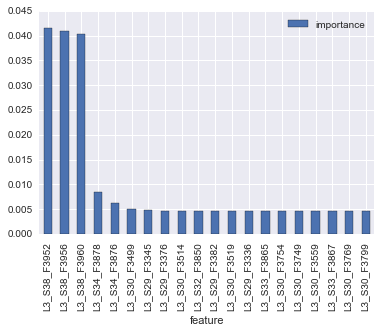

In [28]:
# plot top 20 features
xt_feat_imp.sort_values(by="importance", ascending=False)[:20].plot(y="importance", x="feature", kind="bar")

In [29]:
# use pre-written feature selection methods to determine 
xt_sfm = SelectFromModel(xt_clf, prefit=True)

In [30]:
xt_sfm_support = xt_sfm.get_support()

In [31]:
xt_sfm_features = map(lambda y: y[1], filter(lambda x: xt_sfm_support[x[0]], enumerate(features)))

In [ ]:
# random forest feature selection

In [32]:
rfc_clf = RandomForestClassifier(n_estimators=10, verbose=2)

In [33]:
rfc_clf.fit(X_train, y_train)

building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  5.4min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=2,
            warm_start=False)

In [34]:
prediction = rfc_clf.predict(X_test)

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.6s finished


In [35]:
print "Random Forest Classifier Accuracy Score: %s" % (accuracy_score(y_true=y_test, y_pred=prediction) * 100)
print "Random Forest Hit Score: %s" % hit_score(y_true=y_test, y_pred=prediction, hit_class=1)
print "Random Forest Classification Report:"
print classification_report(y_true=y_test, y_pred=prediction, digits=3)

Random Forest Classifier Accuracy Score: 99.4261175642
Random Forest Hit Score: 1.89688715953
Random Forest Classification Report:
             precision    recall  f1-score   support

          0      0.994     1.000     0.997    353069
          1      0.650     0.019     0.037      2056

avg / total      0.992     0.994     0.992    355125



In [36]:
rf_feat_imp = get_feat_imp(rfc_clf, features)

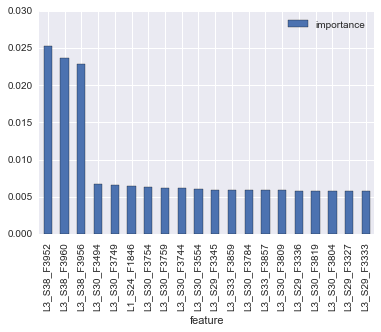

In [37]:
# plot top 20 features based on random forest results
rf_feat_imp.sort_values(by="importance", ascending=False)[:20].plot(y="importance", x="feature", kind="bar")

In [38]:
rf_sfm = SelectFromModel(rfc_clf, prefit=True)

In [39]:
rf_sfm_support = rf_sfm.get_support()

In [40]:
rf_sfm_features = map(lambda y: y[1], filter(lambda x: rf_sfm_support[x[0]], enumerate(features)))

In [ ]:
# GBM classifier

In [43]:
gb_clf = GradientBoostingClassifier(n_estimators=10, verbose=2)

In [44]:
gb_clf.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.0697            3.30m
         2           0.0671            2.79m
         3           0.0664            2.38m
         4           0.0661            2.01m
         5           0.0659            1.66m
         6           0.0658            1.32m
         7           0.0657           58.39s
         8           0.0652           38.17s
         9           0.0651           18.88s
        10           0.0650            0.00s


GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              presort='auto', random_state=None, subsample=1.0, verbose=2,
              warm_start=False)

In [45]:
prediction = gb_clf.predict(X_test)

In [46]:
print "Gradient Boost Accuracy Score: %s" % (accuracy_score(y_true=y_test, y_pred=prediction) * 100)
print "Gradient Boost Hit Score: %s" % hit_score(y_true=y_test, y_pred=prediction, hit_class=1)
print "Gradient Boost Classification Report:"
print classification_report(y_true=y_test, y_pred=prediction, digits=3)

Gradient Boost Accuracy Score: 99.4340021119
Gradient Boost Hit Score: 5.30155642023
Gradient Boost Classification Report:
             precision    recall  f1-score   support

          0      0.995     1.000     0.997    353069
          1      0.634     0.053     0.098      2056

avg / total      0.992     0.994     0.992    355125



In [47]:
gb_feat_imp = get_feat_imp(gb_clf, features)

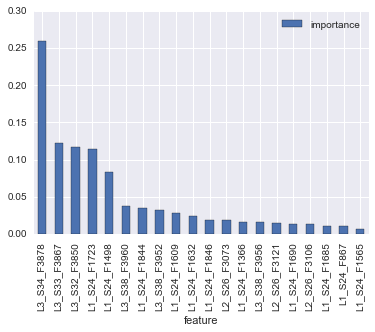

In [49]:
# plot importance for top 20 features as determined by gbm
gb_feat_imp.sort_values(by="importance", ascending=False)[:20].plot(y="importance", x="feature", kind="bar")

In [50]:
gb_sfm = SelectFromModel(gb_clf, prefit=True)

In [51]:
gb_sfm_support = gb_sfm.get_support()

In [52]:
gb_sfm_features = map(lambda y: y[1], filter(lambda x: gb_sfm_support[x[0]], enumerate(features)))

In [55]:
features_iter_1 = list(set(xt_sfm_features + rf_sfm_features + gb_sfm_features))

In [56]:
len(features_iter_1)

286

In [62]:
# output merged features to csv
pd.DataFrame(features_iter_1, columns=["features"]).to_csv("ensemble_sfm_features.csv")

In [65]:
# merged feature importance dataframes and output to csv
merged_feat_imp = xt_feat_imp.merge(rf_feat_imp, on="feature", copy=False, suffixes=("_xt", "_rf"), how="outer")

In [67]:
merged_feat_imp = merged_feat_imp.merge(gb_feat_imp, on="feature", copy=False, how="outer")

In [69]:
merged_feat_imp.columns = ["feature", "importance_xt", "importance_rf", "importance_gb"]

In [71]:
merged_feat_imp.to_csv("ensemble_merged_feat_rank.csv")

<br>

## Model Training and Evaluation
With the newly generated feature subset, three different models were used for training and evaluation. Of the two ensemble (GradientBoost, RandomForest) and SVM (LinearSVC) estimators, the Random Forest Classifier training resulted in the highest precision (i.e. small number of false positives) of 89.2%.

In [72]:
# use subset of features with ensemble methods and linear svc to test overall performance

In [73]:
gb_clf = GradientBoostingClassifier(n_estimators=100, verbose=2)

In [74]:
X_new = df_numeric_mean[features_iter_1].values

In [75]:
X_new_train = X_new[:int(0.7*len(X_new))]
X_new_test = X_new[int(0.7*len(X_new)):]

In [77]:
gb_clf.fit(X_new_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.0697           14.89m
         2           0.0671           15.10m
         3           0.0664           14.96m
         4           0.0661           14.81m
         5           0.0659           14.65m
         6           0.0658           14.49m
         7           0.0657           14.24m
         8           0.0652           13.93m
         9           0.0651           13.73m
        10           0.0650           13.56m
        11           0.0649           13.45m
        12           0.0648           13.28m
        13           0.0647           13.10m
        14           0.0647           12.96m
        15           0.0646           12.90m
        16           0.0645           12.72m
        17           0.0645           12.55m
        18           0.0643           12.49m
        19           0.0643           12.30m
        20           0.0642           12.30m
        21           0.0641           12.19m
        2

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=2,
              warm_start=False)

In [79]:
prediction = gb_clf.predict(X_new_test)

In [80]:
scoring_report(y_test, prediction, estimator_type="Gradient Boost")

Gradient Boost Accuracy Score: 99.4269623372
Gradient Boost Hit Score: 4.71789883268
Gradient Boost Classification Report:
             precision    recall  f1-score   support

          0      0.994     1.000     0.997    353069
          1      0.561     0.047     0.087      2056

avg / total      0.992     0.994     0.992    355125



In [ ]:
# test support vector machine with linear kernel and subset of features

In [81]:
lsvm = LinearSVC(verbose=2)

In [82]:
lsvm.fit(X_new_train, y_train)

[LibLinear]

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=2)

In [83]:
prediction = lsvm.predict(X_new_test)

In [84]:
scoring_report(y_test, prediction, estimator_type="LinearSVC")

LinearSVC Accuracy Score: 99.4227384724
LinearSVC Hit Score: 0.632295719844
LinearSVC Classification Report:
             precision    recall  f1-score   support

          0      0.994     1.000     0.997    353069
          1      0.650     0.006     0.013      2056

avg / total      0.992     0.994     0.991    355125



## Best Performing Estimator

In [85]:
rf_clf = RandomForestClassifier(n_estimators=100, verbose=2, oob_score=True)

In [86]:
rf_clf.fit(X_new_train, y_train)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed: 18.6min


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 47.1min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=None, verbose=2, warm_start=False)

In [87]:
prediction = rf_clf.predict(X_new_test)

[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   19.4s finished


In [88]:
scoring_report(y_test, prediction, estimator_type="Random Forest")

Random Forest Accuracy Score: 99.4354100669
Random Forest Hit Score: 2.82101167315
Random Forest Classification Report:
             precision    recall  f1-score   support

          0      0.994     1.000     0.997    353069
          1      0.892     0.028     0.055      2056

avg / total      0.994     0.994     0.992    355125



## Under-Sampling
A secondary test was performed with the best performing estimator, wherein the feature space was altered such that there existed a lesser proportion of the over-represented class.

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=100, verbose=2)
positives_X = X_new_train[y_train == 1]
positives_y = y_train[y_train == 1]
negatives_X = X_new_train[y_train == 0]
negatives_y = y_train[y_train == 0]

In [130]:
for proportion in [0.01, 0.03, 0.05, 0.1, 0.3, 0.5]:
    print "proportion of over-represented class: %s" % proportion
    # use stratified shuffle split to over-represented class
    sss = StratifiedShuffleSplit(negatives_y, n_iter=1, train_size=proportion)
     
    train_index, test_index = [(train, test) for train, test in sss][0]
    
    X_new_train = np.concatenate((negatives_X[train_index], positives_X[:int(0.8*len(positives_X))]), axis=0)
    y_new_train = np.concatenate((negatives_y[train_index], positives_y[:int(0.8*len(positives_y))]), axis=0)
    print "X train shape: {}".format(X_new_train.shape)
    print "Y train shape: {}".format(y_new_train.shape)
    
    X_new_test = np.concatenate((negatives_X[test_index], positives_X[int(0.8*len(positives_X)):]), axis=0)
    y_new_test = np.concatenate((negatives_y[test_index], positives_y[int(0.8*len(positives_y)):]), axis=0)
    print "X test shape: {}".format(X_new_test.shape)
    print "Y test shape: {}".format(y_new_test.shape)
    
    # split positive train and test set 80/20
    rf_clf.fit(X_new_train, y_new_train)
    
    prediction = rf_clf.predict(X_new_test)
    
    scoring_report(y_new_test, prediction, estimator_type="Random Forest")

proportion of over-represented class: 0.01
(8237, 286)
(3858, 286)
X train shape: (12095, 286)
Y train shape: (12095,)
X test shape: (83345, 286)
Y test shape: (83345,)
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100


[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    2.9s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.3s finished
[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished


Random Forest Accuracy Score: 96.2313276141
Random Forest Hit Score: 23.1088082902
Random Forest Classification Report:
             precision    recall  f1-score   support

          0      0.991     0.971     0.981     82380
          1      0.085     0.231     0.124       965

avg / total      0.980     0.962     0.971     83345

proportion of over-represented class: 0.03
(24713, 286)
(3858, 286)
X train shape: (28571, 286)
Y train shape: (28571,)
X test shape: (83345, 286)
Y test shape: (83345,)
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100


[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:   11.3s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   28.9s finished
[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.1s finished


Random Forest Accuracy Score: 98.2626432299
Random Forest Hit Score: 18.5492227979
Random Forest Classification Report:
             precision    recall  f1-score   support

          0      0.990     0.992     0.991     82380
          1      0.213     0.185     0.198       965

avg / total      0.981     0.983     0.982     83345

proportion of over-represented class: 0.05
(41189, 286)
(3858, 286)
X train shape: (45047, 286)
Y train shape: (45047,)
X test shape: (83345, 286)
Y test shape: (83345,)
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100


[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:   21.6s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   54.7s finished
[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.4s finished


Random Forest Accuracy Score: 98.4618153459
Random Forest Hit Score: 17.3056994819
Random Forest Classification Report:
             precision    recall  f1-score   support

          0      0.990     0.994     0.992     82380
          1      0.257     0.173     0.207       965

avg / total      0.982     0.985     0.983     83345

proportion of over-represented class: 0.1
(82379, 286)
(3858, 286)
X train shape: (86237, 286)
Y train shape: (86237,)
X test shape: (83345, 286)
Y test shape: (83345,)
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
b

[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:   56.3s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.5s finished


Random Forest Accuracy Score: 98.57100006
Random Forest Hit Score: 15.2331606218
Random Forest Classification Report:
             precision    recall  f1-score   support

          0      0.990     0.995     0.993     82380
          1      0.283     0.152     0.198       965

avg / total      0.982     0.986     0.984     83345

proportion of over-represented class: 0.3
(247139, 286)
(3858, 286)
X train shape: (250997, 286)
Y train shape: (250997,)
X test shape: (83345, 286)
Y test shape: (83345,)
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100


[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:  3.3min


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  8.3min finished
[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.7s finished


Random Forest Accuracy Score: 98.7089807427
Random Forest Hit Score: 7.04663212435
Random Forest Classification Report:
             precision    recall  f1-score   support

          0      0.989     0.998     0.993     82380
          1      0.275     0.070     0.112       965

avg / total      0.981     0.987     0.983     83345

proportion of over-represented class: 0.5
(411899, 286)
(3858, 286)
X train shape: (415757, 286)
Y train shape: (415757,)
X test shape: (83345, 286)
Y test shape: (83345,)
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 10

[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:  8.3min


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 19.6min finished
[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.8s finished


Random Forest Accuracy Score: 98.6945827584
Random Forest Hit Score: 3.31606217617
Random Forest Classification Report:
             precision    recall  f1-score   support

          0      0.989     0.998     0.993     82380
          1      0.171     0.033     0.056       965

avg / total      0.979     0.987     0.983     83345



<br>

## Miscellaneous and Previous Analysis

In [5]:
df_tags = df_numeric[["Id", "Response"]]
len(df_numeric)

1183747

In [6]:
# group features into lines and stations
lines = {}
for col in df_numeric.columns[1:-1]:
    piece = [pc[1:] for pc in col.split("_")]
    
    if len(piece) != 3:
        print "Invalid column format: %s" % col
        continue
        
    if piece[0] not in lines:
        lines[piece[0]] = {}
    
    if piece[1] not in lines[piece[0]]:
        lines[piece[0]][piece[1]] = []
    
    lines[piece[0]][piece[1]].append((piece[2], col))

In [7]:
print len(lines['0'])
print sum([len(lines['0'][col]) for col in lines['0']])
print len(lines['1'])
print sum([len(lines['1'][col]) for col in lines['1']])
print len(lines['2'])
print sum([len(lines['2'][col]) for col in lines['2']])
print len(lines['3'])
print sum([len(lines['3'][col]) for col in lines['3']])

24
168
2
513
3
42
21
245


In [8]:
# analysis of line 2 data
lines['2'].keys()

['26', '27', '28']

In [19]:
df_226 = df_numeric[[tup[1] for tup in lines['2']['26']] + ['Id', 'Response']]

In [ ]:
# create uid string column and set as index
df_226["uid"] = df_226["Id"].apply(lambda x: str(x))
df_226.drop("Id", inplace=True, axis=1)
df_226.set_index("uid", inplace=True)

In [ ]:
# remove Response so that we can correctly check isnull()
df_226.drop("Response", inplace=True, axis=1)

In [37]:
nan_226 = strictly_nan(df_226.T)

In [39]:
df_226_cut = df_226.T[list(set(df_226.T.columns) - set(nan_226))].T

In [6]:
# only use the first three hundred thousand rows
df_numeric = df_numeric[:300000]

In [7]:
df_numeric.head()

,Id,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,...,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262,Response
0,4,0.030,-0.034,-0.197,-0.179,0.118,0.116,-0.015,-0.032,0.020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,7,0.088,0.086,0.003,-0.052,0.161,0.025,-0.015,-0.072,-0.225,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,9,-0.036,-0.064,0.294,0.330,0.074,0.161,0.022,0.128,-0.026,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,11,-0.055,-0.086,0.294,0.330,0.118,0.025,0.030,0.168,-0.169,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [9]:
# split data set into failures and passes
df_fail = df_numeric[df_numeric["Response"] == 0]
df_pass = df_numeric[df_numeric["Response"] == 1]

In [ ]:
# create dataframe with switch frequencies
sw_freq = {}
for col in df_numeric.columns[1:-1]:
    sw_freq[col] = switch_frequency(df_numeric[col], df_numeric.Response)

In [77]:
df_sf = pd.DataFrame([sw_freq.keys(), sw_freq.values()]).T
df_sf.columns=["feature", "switch_freq"]

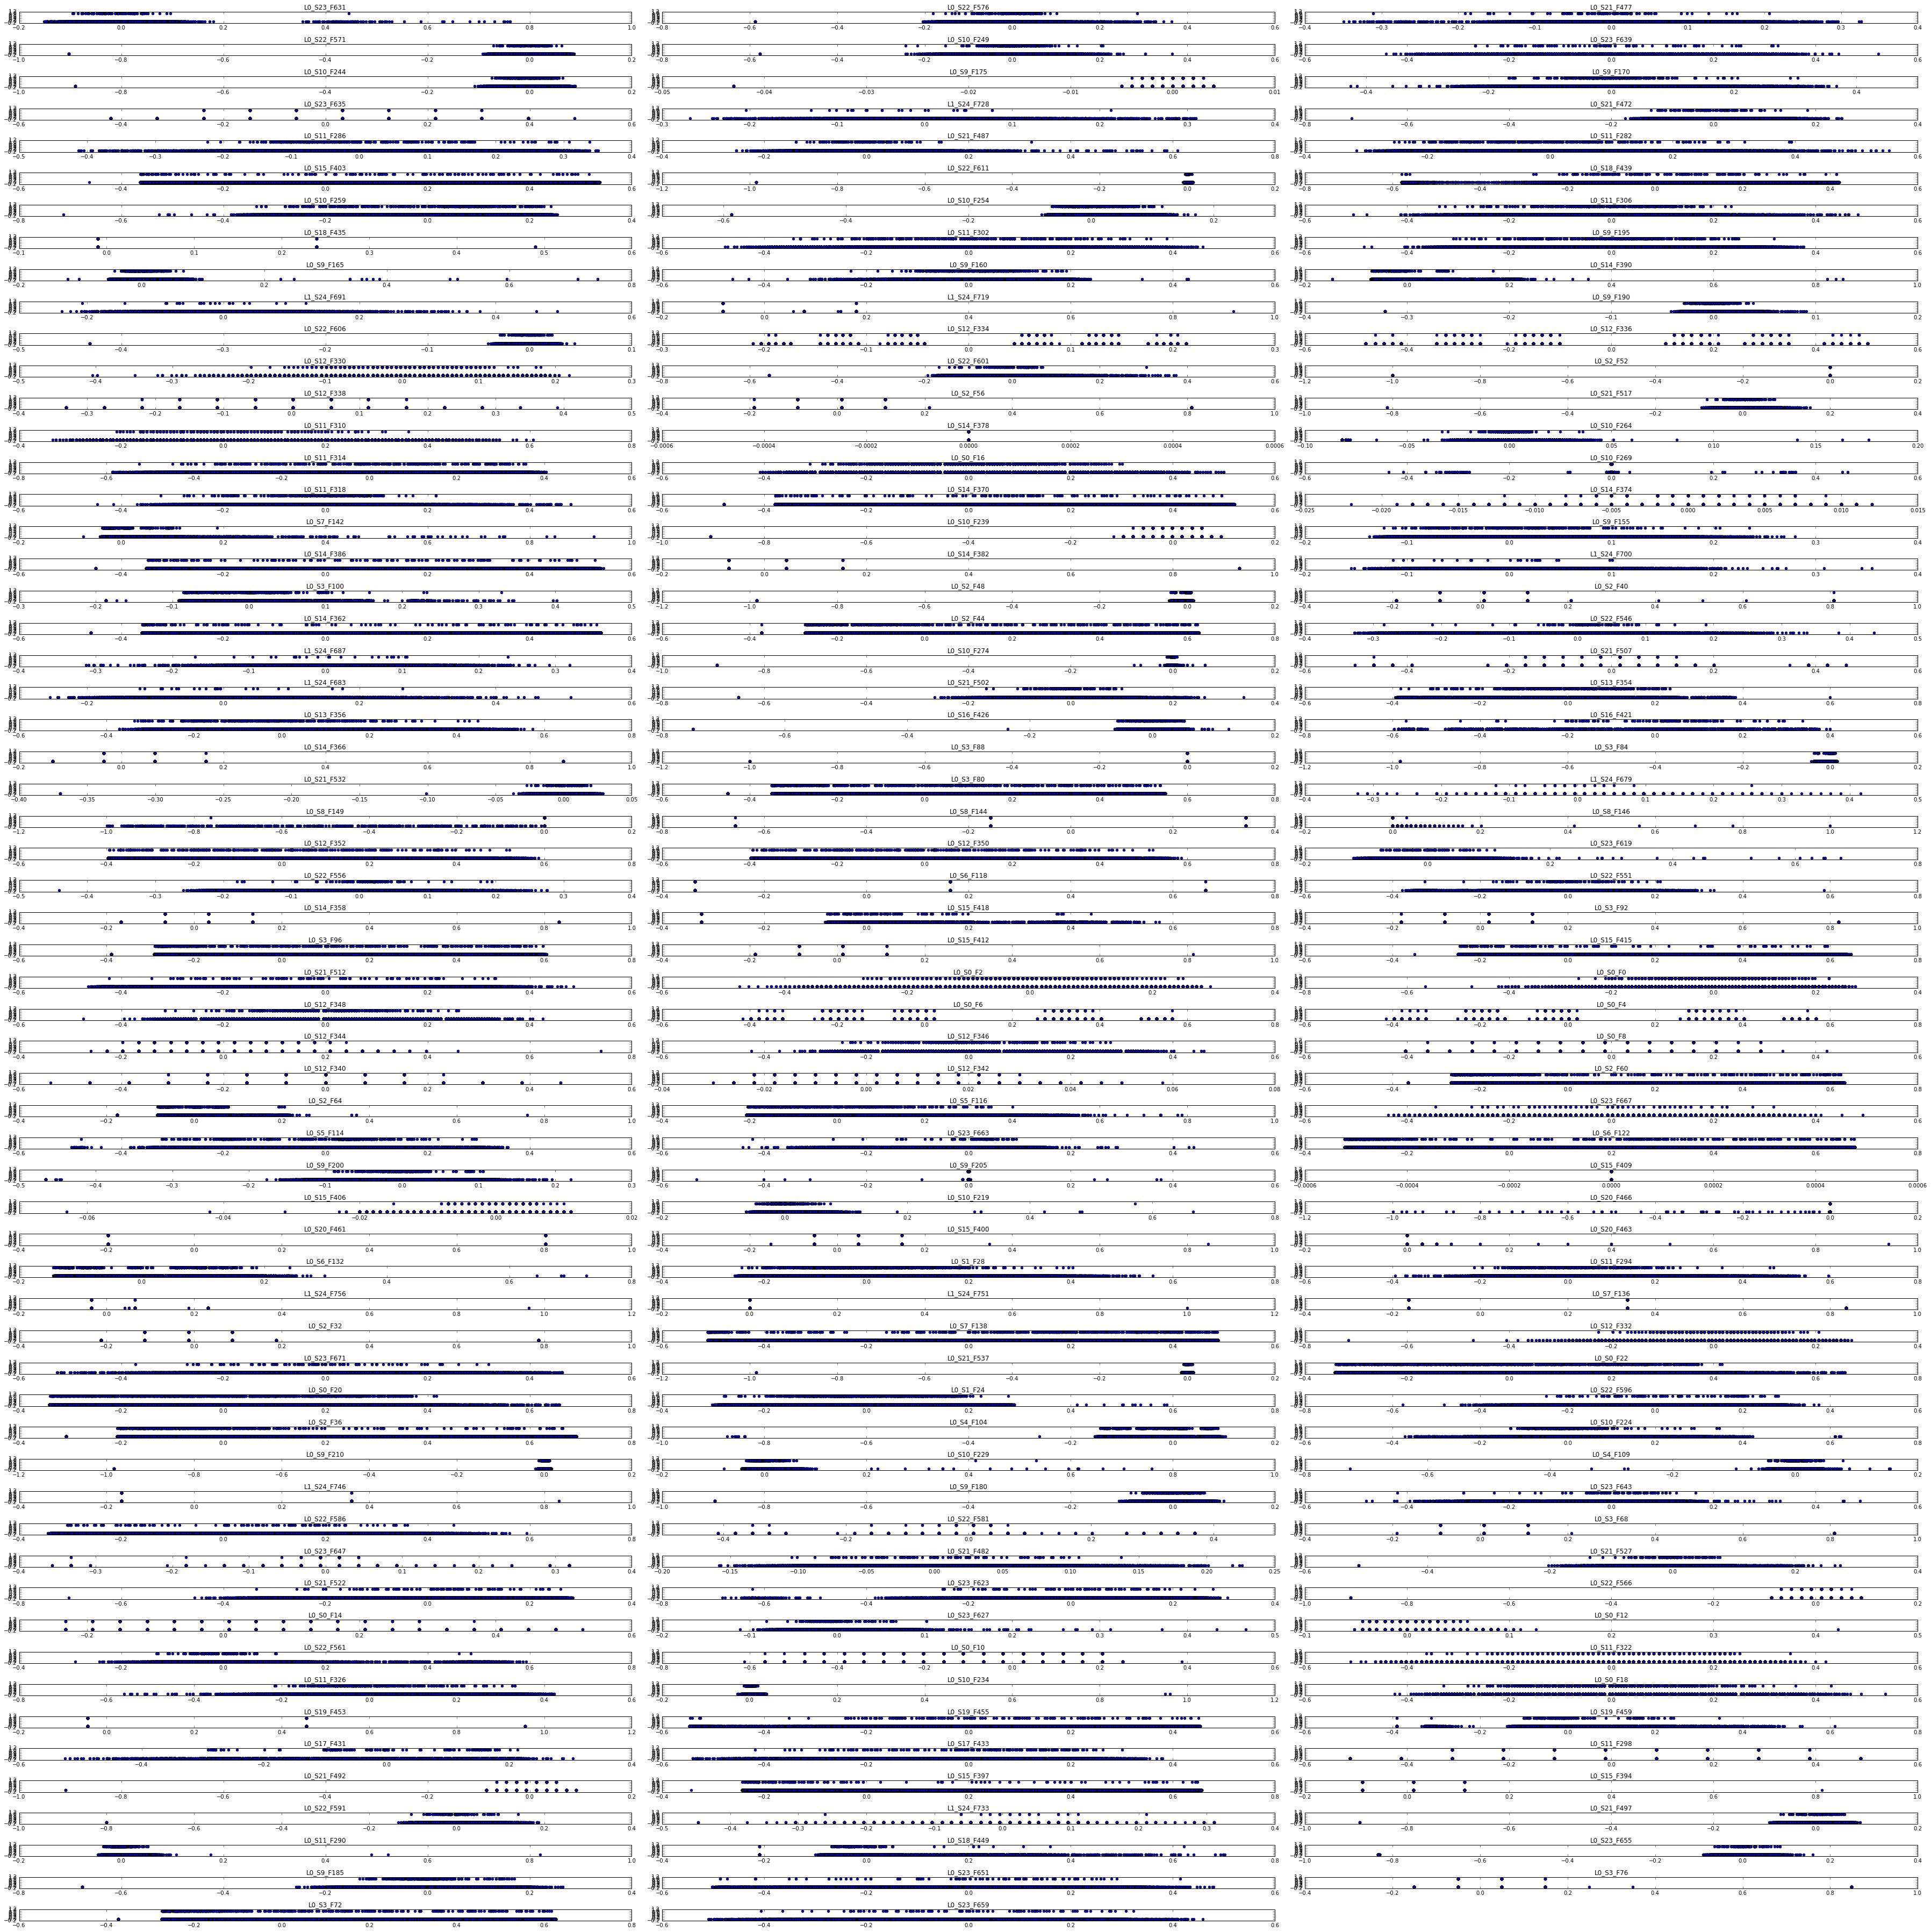

In [126]:
feature_trends(df_numeric, "Response", figsize=(50,50), size=(60,3), ignore=["Id", "Response"])

In [80]:
df_sf.head()

,feature,switch_freq
0,L2_S27_F3162,331
1,L3_S47_F4168,151
2,L1_S24_F1260,25
3,L1_S24_F1265,25
4,L3_S41_F4002,150


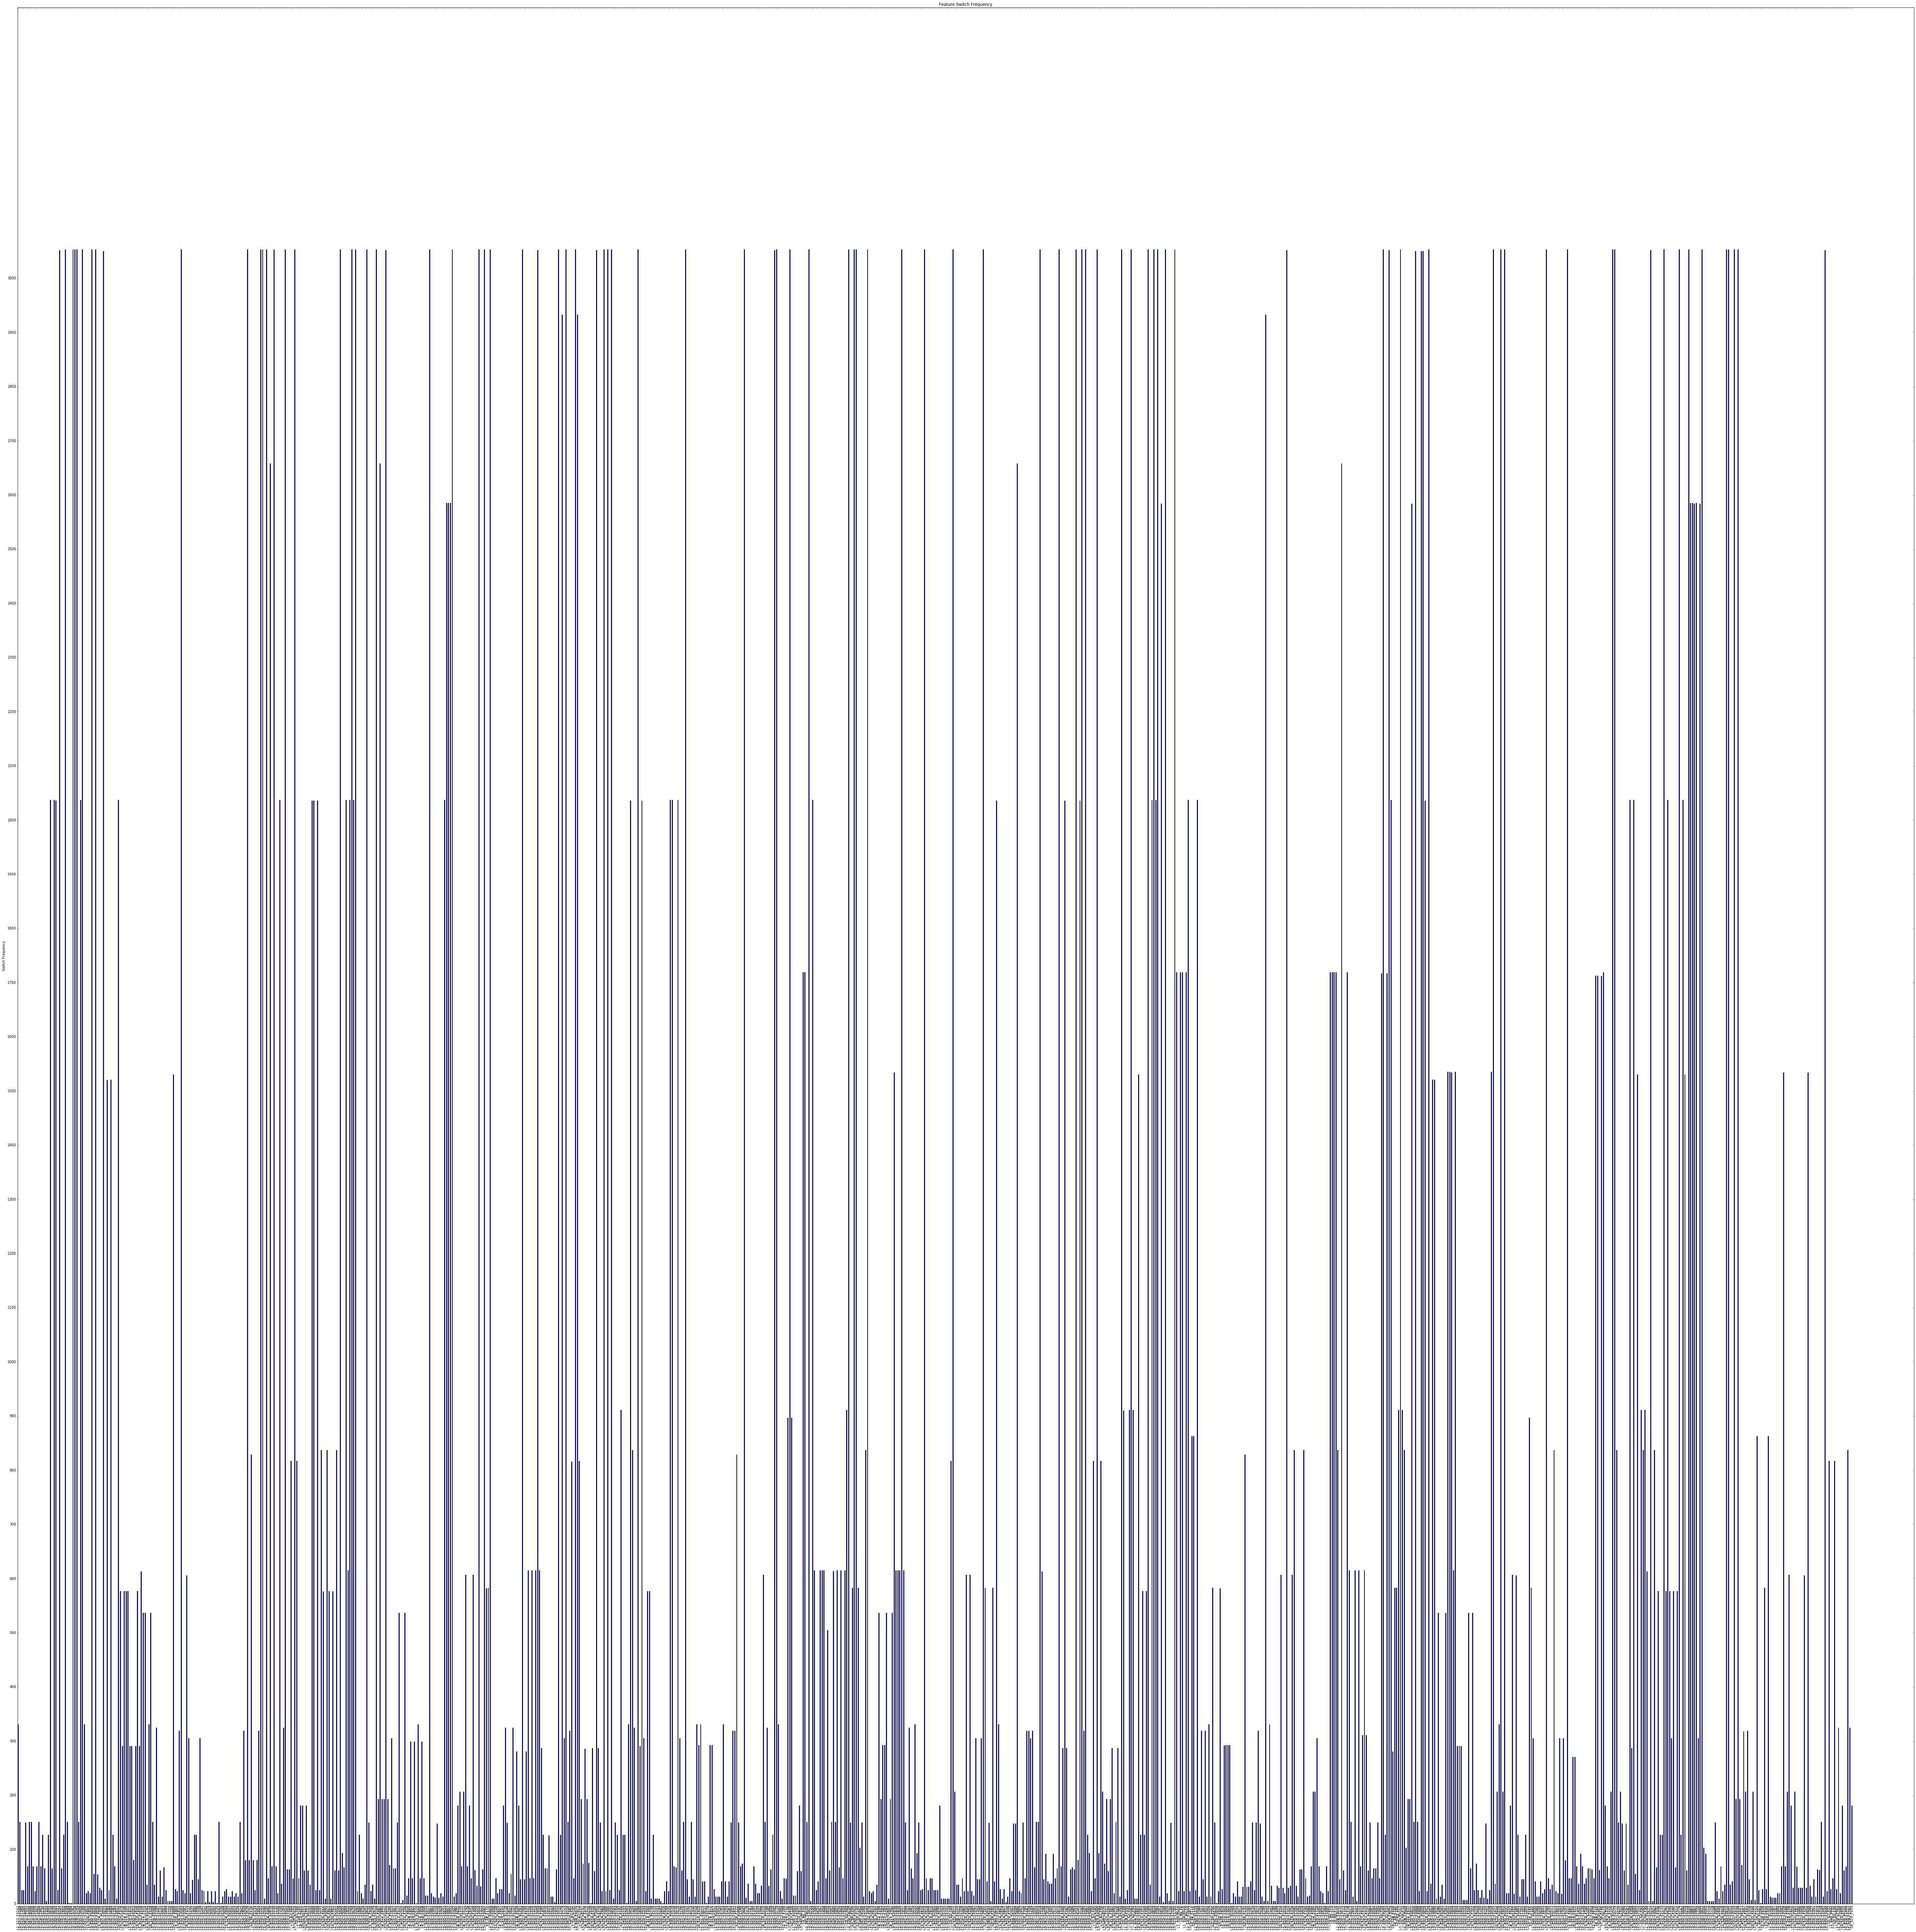

In [95]:
# bar graph - need to figure out how to set vertical xticks
fig2 = plt.figure(figsize=(100,100))
axes = fig2.add_subplot(1,1,1)
axes.bar(np.arange(len(df_sf["switch_freq"])), df_sf["switch_freq"], 0.35)
plt.ylabel('Switch Frequency')
plt.title("Feature Switch Frequency")
plt.xticks(np.arange(len(df_sf["switch_freq"])) + 0.35/2, df_sf["feature"], rotation='vertical')
plt.yticks(np.arange(0, df_sf["switch_freq"].max(), 100))
plt.show()

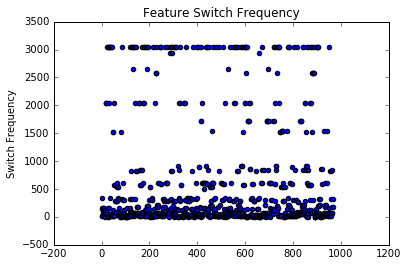

In [96]:
# scatter plot of switch frequencies
fig3 = plt.figure()
axes = fig3.add_subplot(1,1,1)
axes.scatter(np.arange(len(df_sf["switch_freq"])), df_sf["switch_freq"])
plt.ylabel("Switch Frequency")
plt.title("Feature Switch Frequency")
plt.show()

In [ ]:
# conducting nan analysis and model building from this point

In [173]:
# obtain nan frequencies - recognize that Id, Response will have freq = 0
nan_freq = {col: len(filter(lambda x: x, df_numeric[col].isnull())) for col in df_numeric.columns}

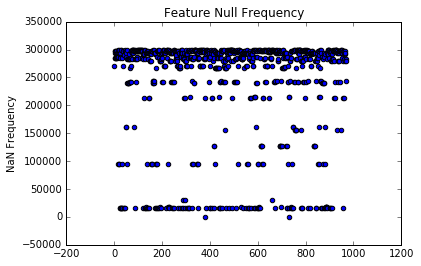

In [174]:
fig = plt.figure()
axes = fig.add_subplot(1,1,1)
axes.scatter(np.arange(len(nan_freq)), nan_freq.values())
plt.ylabel('NaN Frequency')
plt.title('Feature Null Frequency')
plt.show()

In [177]:
df_nf = pd.DataFrame([nan_freq.keys(), nan_freq.values()]).T
df_nf.columns = ["Feature", "NaN_Freq"]

In [187]:
print "Min null value count: %s" % df_nf.NaN_Freq.min()
print "Max null value count: %s" % df_nf.NaN_Freq.max()

print "# of features with 250,000 <= null value count <= 300,000: %s" % len(df_nf[(df_nf["NaN_Freq"] > 250000) & (df_nf["NaN_Freq"] < 300000)])

Min null value count: 0
Max null value count: 299706
# of features with 250,000 <= null value count <= 300,000: 701


In [196]:
# create a copy of df_numeric for nan filling
# every copy of df_numeric must be "deleted" once model is built
df_num_nan = df_numeric.copy()

In [324]:
# check memory usage 
import os
import psutil
process = psutil.Process(os.getpid())
print "Total memory ~ %sGB" % (process.memory_info().rss / (10**9))

Total memory ~ 1GB


In [ ]:
# dumb model with all features
from sklearn import linear_model

# preserve NaNs for further analysis => use reduced-models approach and 
df_num_model = df_numeric.fillna()

x = df_numeric[[col for col in df_numeric.columns if col not in ["Id", "Response"]]].values
y = df_numeric["Response"].values

clf = linear_model.SGDClassifier(loss="log")
clf.fit(x, y)

In [296]:
# simple model to compute all features
def sgd_class(data, target, test, loss="log"):
    """
        Stochastic Gradient Classifier with log loss (i.e. fits logistic
        regression model).
        
        Parameters
        ----------
        data : {pandas.DataFrame}
            training data
        
        target : {pandas.Series}
            response variable
            
        test : {pandas.DataFrame}
            test data
        
        loss : {string}
            loss function to follow when classifying; defaults to 'log'
            in order to force logistic regression model
    """
    X = data.values
    y = target.values
    
    # we tweak params here as we deem appropriate
    clf = linear_model.SGDClassifier(loss=loss)
    
    clf.fit(X, y)
    
    return clf.predict(test.values)

In [307]:
sgd_class(nan_transform(test.drop(["Id", 4], axis=1)), test[4], test_test)

array([1, 0, 1, 1])

In [308]:
df_test_num = pd.read_csv("test_numeric.csv")

In [322]:
# remember that numeric test has already been loaded
df_test_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1183748 entries, 0 to 1183747
Columns: 969 entries, Id to L3_S51_F4262
dtypes: float64(968), int64(1)
memory usage: 8.5 GB


In [329]:
# split (already reduced) training data into training and test sets
df_num_train = df_numeric[:240000]
df_num_test = df_numeric[240000:]

In [330]:
df_num_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240000 entries, 0 to 239999
Columns: 970 entries, Id to Response
dtypes: float64(968), int64(2)
memory usage: 1.7 GB


In [331]:
df_num_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 240000 to 299999
Columns: 970 entries, Id to Response
dtypes: float64(968), int64(2)
memory usage: 444.0 MB


In [335]:
# show truly independent data sets
set(df_num_train["Id"].values) & set(df_num_test["Id"].values)

set()

In [336]:
df_num_train.head()

,Id,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,...,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262,Response
0,4,0.030,-0.034,-0.197,-0.179,0.118,0.116,-0.015,-0.032,0.020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,7,0.088,0.086,0.003,-0.052,0.161,0.025,-0.015,-0.072,-0.225,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,9,-0.036,-0.064,0.294,0.330,0.074,0.161,0.022,0.128,-0.026,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,11,-0.055,-0.086,0.294,0.330,0.118,0.025,0.030,0.168,-0.169,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [337]:
df_num_test.head()

,Id,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,...,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262,Response
240000,480068,-0.055,-0.078,0.33,0.348,-0.143,0.025,0.03,0.168,0.183,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
240001,480070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
240002,480072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
240003,480073,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
240004,480074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [373]:
prediction = sgd_class(nan_transform(df_num_train.drop(["Id", "Response"], axis=1), method="mean"), df_num_train["Response"], nan_transform(df_num_test.drop(["Id", "Response"], axis=1)), loss="log")

In [374]:
result = pd.DataFrame(zip(df_num_test["Id"], prediction), columns=["Id", "Response"])

In [375]:
# run evaluation for mean imputation
print "MCC evaluation: %s" % mcc_eval(result, df_num_test[["Id", "Response"]])

true positives: 1
true negatives: 2
false positives: 0
false negatives: 0
MCC evaluation: 1.0


In [370]:
prediction = sgd_class(nan_transform(df_num_train.drop(["Id", "Response"], axis=1), method="median"), df_num_train["Response"], nan_transform(df_num_test.drop(["Id", "Response"], axis=1), method="median"))

In [372]:
# run evaluation for median imputation
print "MCC evaluation: %s" % mcc_eval(pd.DataFrame(zip(df_num_test["Id"], prediction), columns=["Id", "Response"]), df_num_test[["Id", "Response"]])

true positives: 1
true negatives: 2
false positives: 0
false negatives: 0
MCC evaluation: 1.0


In [ ]:
# run evaluation for feature average imputation
prediction = sgd_class(nan_transform(df_num_train.drop(["Id", "Response"], axis=1), method="feature_average"), df_num_train["Response"], nan_transform(df_num_test.drop(["Id", "Response"], axis=1), method="feature_average"))
print "MCC evaluation: %s" % mcc_eval(pd.DataFrame(zip(df_num_test["Id"], prediction), columns=["Id", "Response"]), df_num_test[["Id", "Response"]])

In [ ]:
# should try principal component analysis for dimensionality reduction
# http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html